In [1]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import *

from utils import *
from model.loss import *
from diffusion_dist import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import phate

In [39]:
symsim_r1b1 = hhRNA1(standardize=False, rna_seq_file = "./data/human_hematopoiesis/count_rna.csv", rna_celltype_file = "./data/human_hematopoiesis/celltypes_rna.txt")
symsim_r1b2 = hhATAC1(standardize=False, atac_seq_file = "./data/human_hematopoiesis/count_atac.csv", atac_celltype_file = "./data/human_hematopoiesis/celltypes_atac.txt")

symsim_r1b1_CONFIG = { 
    'in_features': 500,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256, # batch size need to be large enough to represent the population
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

symsim_r1b2_CONFIG = { 
    'in_features': 1764,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

train_r1b1_loader = DataLoader(symsim_r1b1, batch_size = symsim_r1b1_CONFIG["minibatch_size"], shuffle = True)
train_r1b2_loader = DataLoader(symsim_r1b2, batch_size = symsim_r1b1_CONFIG["minibatch_size"], shuffle = True)
test_r1b1_loader = DataLoader(symsim_r1b1, batch_size = len(symsim_r1b1), shuffle = False)
test_r1b2_loader = DataLoader(symsim_r1b2, batch_size = len(symsim_r1b2), shuffle = False)

for data in test_r1b1_loader:
    U_t1, Diff1 = phate_similarity(data["raw"], 
                                  # control radius with decay
                                  n_neigh = 5, 
                                  t = 15, 
                                  use_potential = True, 
                                  # control radius with decay, if thresh equals to 0, the decaying of the kernel function is still calculated adaptively, with the equation np.exp(-1 * np.power(pdx, self.decay)) and pdx = (pdx.T / dist_kth).T
                                  thresh = 0,
                                  # decay gets larger, the radius get smaller, when decay gets infinity, the radius equals to the exact kth neighbor distance: radius = dist_kth * np.power(-1 * np.log(thresh),1/decay), the node outside the distance will be not connected
                                  # decay gets smaller, can be efficient
                                  decay = 40)

    
    Diff1 = torch.FloatTensor(Diff1).to(device)
    U_t1 = torch.FloatTensor(U_t1).to(device)
    # X_phate1 = phate.PHATE(n_components=2).fit_transform(data["raw"].numpy())


    

for data in test_r1b2_loader:
    U_t2, Diff2 = phate_similarity(data["raw"], 
                                  n_neigh = 5, 
                                  t = 70, 
                                  use_potential = True,
                                  thresh = 0,
                                  decay = 10)


      
    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    U_t2 = torch.FloatTensor(U_t2).to(device)
    # X_phate2 = phate.PHATE(n_components=2).fit_transform(data["raw"].numpy())

In [40]:
# plot_latent(z1 = X_phate1, z2 = X_phate2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "separate",save = None)

In [41]:
from collections import OrderedDict

ae1 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_r1b1_CONFIG)), 
        ("decoder", ae.Decoder(symsim_r1b1_CONFIG))
      ])).to(device)

ae2 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_r1b2_CONFIG)), 
        ("decoder", ae.Decoder(symsim_r1b2_CONFIG))
      ])).to(device)

disc = ae.discriminator(hidden1 = 64, hidden2 = 32, hidden3 = 1).to(device)

optimizer_rna = torch.optim.Adam(ae1.parameters(), lr = 1e-3)
optimizer_atac = torch.optim.Adam(ae2.parameters(), lr = 1e-3)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 1e-3)

In [42]:
pre_train_ae(model = ae1, data_loader = train_r1b1_loader, diff_sim = Diff1, optimizer = optimizer_rna, P = U_t1, n_epochs = 101, lambda_r = 0, dist_mode = "mse")

epoch:  0 Total loss: 0.22921, recon loss: 0.00000, dist loss: 0.22921
epoch:  10 Total loss: 0.08824, recon loss: 0.00000, dist loss: 0.08824
epoch:  20 Total loss: 0.09038, recon loss: 0.00000, dist loss: 0.09038
epoch:  30 Total loss: 0.09569, recon loss: 0.00000, dist loss: 0.09569
epoch:  40 Total loss: 0.07312, recon loss: 0.00000, dist loss: 0.07312
epoch:  50 Total loss: 0.07817, recon loss: 0.00000, dist loss: 0.07817
epoch:  60 Total loss: 0.07931, recon loss: 0.00000, dist loss: 0.07931
epoch:  70 Total loss: 0.07324, recon loss: 0.00000, dist loss: 0.07324
epoch:  80 Total loss: 0.08024, recon loss: 0.00000, dist loss: 0.08024
epoch:  90 Total loss: 0.06234, recon loss: 0.00000, dist loss: 0.06234
epoch:  100 Total loss: 0.06756, recon loss: 0.00000, dist loss: 0.06756


In [43]:
pre_train_ae(model = ae2, data_loader = train_r1b2_loader, diff_sim = Diff2, optimizer = optimizer_atac, P = U_t2, n_epochs = 101, lambda_r = 0, dist_mode = "mse")

epoch:  0 Total loss: 0.37718, recon loss: 0.00000, dist loss: 0.37718
epoch:  10 Total loss: 0.06906, recon loss: 0.00000, dist loss: 0.06906
epoch:  20 Total loss: 0.05182, recon loss: 0.00000, dist loss: 0.05182
epoch:  30 Total loss: 0.05338, recon loss: 0.00000, dist loss: 0.05338
epoch:  40 Total loss: 0.03557, recon loss: 0.00000, dist loss: 0.03557
epoch:  50 Total loss: 0.05536, recon loss: 0.00000, dist loss: 0.05536
epoch:  60 Total loss: 0.05072, recon loss: 0.00000, dist loss: 0.05072
epoch:  70 Total loss: 0.04760, recon loss: 0.00000, dist loss: 0.04760
epoch:  80 Total loss: 0.02909, recon loss: 0.00000, dist loss: 0.02909
epoch:  90 Total loss: 0.05654, recon loss: 0.00000, dist loss: 0.05654
epoch:  100 Total loss: 0.02358, recon loss: 0.00000, dist loss: 0.02358


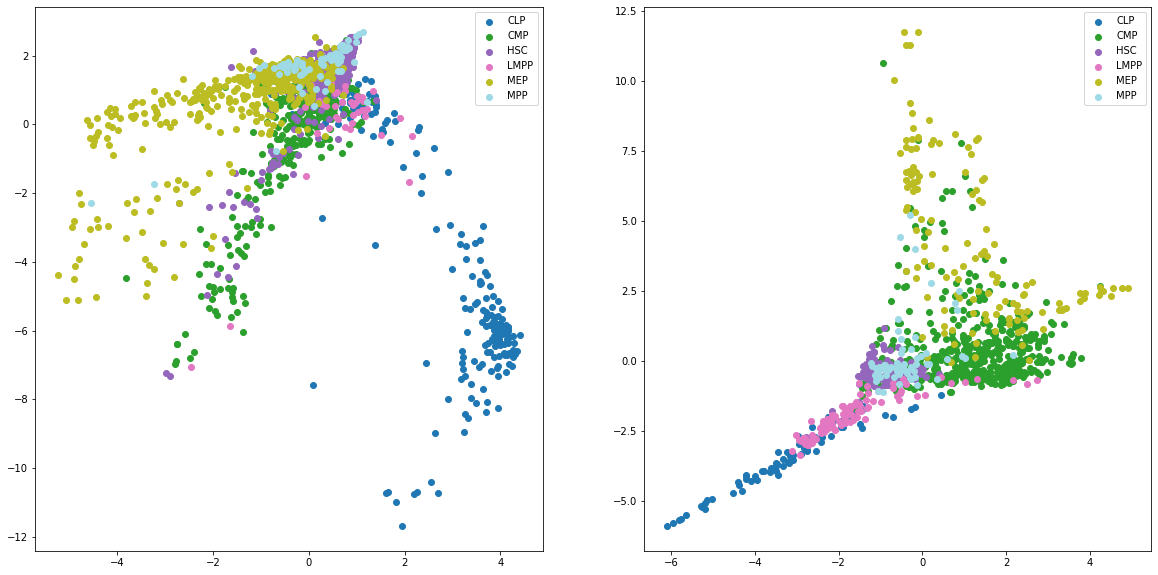

In [44]:
with torch.no_grad():
    for data in test_r1b1_loader:
        ae_coordinates1 = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

    for data in test_r1b2_loader:
        ae_coordinates2 = ae2[:1](data['count'].to(device)).cpu().detach().numpy()

    plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "separate",save = None)

In [45]:
pre_train_disc(model_rna = ae1, model_atac = ae2, disc = disc, data_loader_rna = train_r1b1_loader, data_loader_atac = train_r1b2_loader, optimizer_D = optimizer_D, n_epochs = 101)

epoch:  0 Discriminator loss: 0.68827
epoch:  10 Discriminator loss: 0.54228
epoch:  20 Discriminator loss: 0.42223
epoch:  30 Discriminator loss: 0.35316
epoch:  40 Discriminator loss: 0.32911
epoch:  50 Discriminator loss: 0.31754
epoch:  60 Discriminator loss: 0.28405
epoch:  70 Discriminator loss: 0.27684
epoch:  80 Discriminator loss: 0.28598
epoch:  90 Discriminator loss: 0.25004
epoch:  100 Discriminator loss: 0.28639


In [46]:
# n_iter = 200 merge too good
train_unpaired(ae1, ae2, disc, train_r1b1_loader, train_r1b2_loader, Diff1, Diff2, optimizer_rna, optimizer_atac, optimizer_D, P_rna= U_t1, P_atac= U_t2, n_epochs=201, n_iter=100, n_iter2 = 1, lamb_r_rna = 0, lamb_r_atac = 0, lamb_disc=1, dist_mode = "mse")

epoch:  0 RNA loss: 0.11155, RNA recon loss: 0.00000, RNA dist loss: 0.11155 ATAC loss: 0.06540, ATAC recon loss: 0.00000, ATAC dist loss: 0.06540 Discriminator loss: 0.41226
epoch:  10 RNA loss: 0.13499, RNA recon loss: 0.00000, RNA dist loss: 0.13499 ATAC loss: 0.06559, ATAC recon loss: 0.00000, ATAC dist loss: 0.06559 Discriminator loss: 0.56674
epoch:  20 RNA loss: 0.12789, RNA recon loss: 0.00000, RNA dist loss: 0.12789 ATAC loss: 0.04681, ATAC recon loss: 0.00000, ATAC dist loss: 0.04681 Discriminator loss: 0.59089
epoch:  30 RNA loss: 0.13861, RNA recon loss: 0.00000, RNA dist loss: 0.13861 ATAC loss: 0.04885, ATAC recon loss: 0.00000, ATAC dist loss: 0.04885 Discriminator loss: 0.55442
epoch:  40 RNA loss: 0.13488, RNA recon loss: 0.00000, RNA dist loss: 0.13488 ATAC loss: 0.04156, ATAC recon loss: 0.00000, ATAC dist loss: 0.04156 Discriminator loss: 0.57235
epoch:  50 RNA loss: 0.11948, RNA recon loss: 0.00000, RNA dist loss: 0.11948 ATAC loss: 0.05276, ATAC recon loss: 0.0000

In [47]:
# torch.save({
#     'ae1': ae1.state_dict(),
#     'optim_ae1': optimizer_rna.state_dict(),
#     'ae2': ae2.state_dict(),
#     'optim_ae2': optimizer_rna.state_dict(),
#     'disc': disc.state_dict(),
#     'optim_disc': optimizer_D.state_dict(),
#     'config1': symsim_r1b1_CONFIG,
#     'config2': symsim_r1b2_CONFIG,
#     'Diff1': Diff1,
#     'Diff2': Diff2
# }, './saved_model/hm_phate_new_pretrain.pt')

In [48]:
# state = torch.load('./saved_model/hm_new1.pt')

# ae1 = nn.Sequential(OrderedDict([
#         ("encoder", ae.Encoder(symsim_r1b1_CONFIG)), 
#         ("decoder", ae.Decoder(symsim_r1b1_CONFIG))
#       ])).to(device)
# ae1.load_state_dict(state['ae1'])

# ae2 = nn.Sequential(OrderedDict([
#         ("encoder", ae.Encoder(symsim_r1b2_CONFIG)), 
#         ("decoder", ae.Decoder(symsim_r1b2_CONFIG))
#       ])).to(device)
# ae2.load_state_dict(state['ae2'])

# disc = ae.discriminator().to(device)

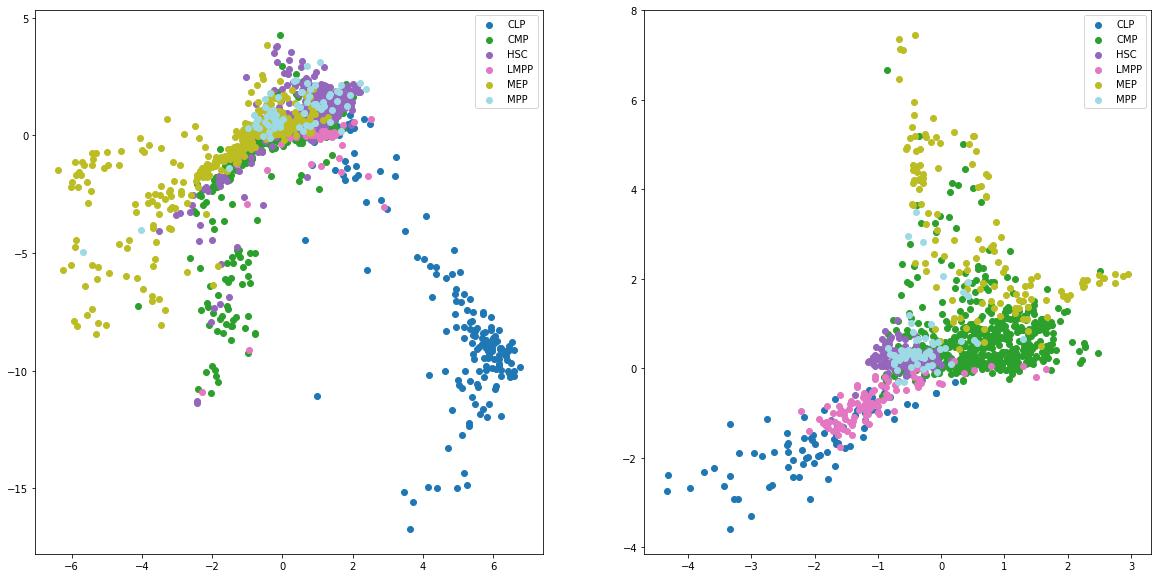

In [49]:
# ATAC radius small n_neigh = 5, decay = 10, thresh = 0, t = 25 the best
ae1.eval()
ae2.eval()

for data in test_r1b1_loader:
    ae_coordinates1 = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

for data in test_r1b2_loader:
    ae_coordinates2 = ae2[:1](data['count'].to(device)).cpu().detach().numpy()

# plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "joint",save = "./result/hm/new/2/joint.pdf")
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "separate",save = None)

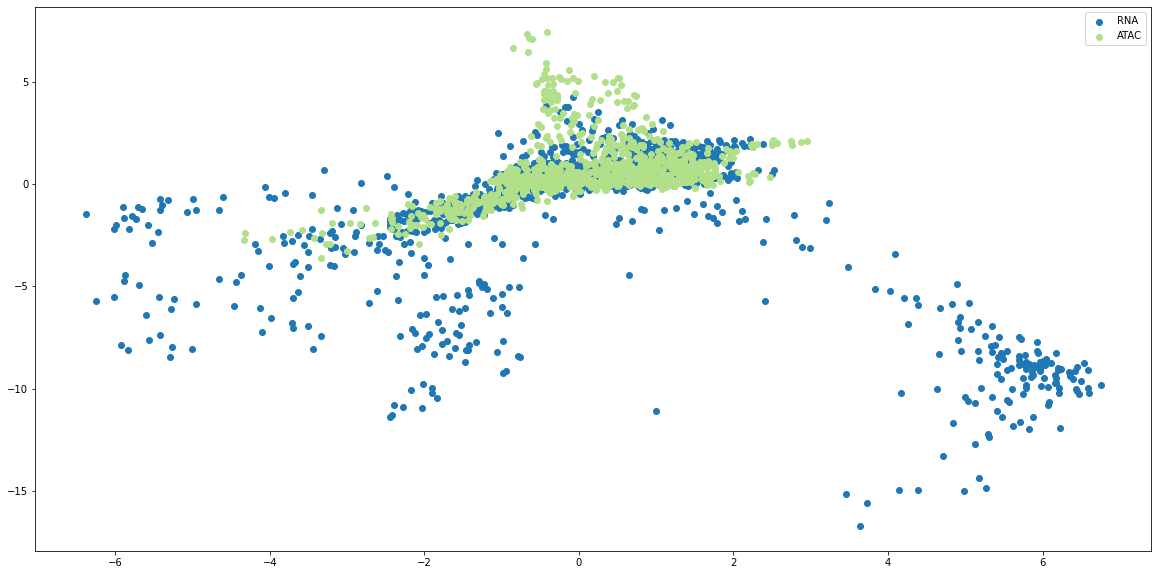

In [50]:
# ATAC radius small n_neigh = 5, decay = 10, thresh = 0, t = 25 the best
ae1.eval()
ae2.eval()

for data in test_r1b1_loader:
    ae_coordinates1 = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

for data in test_r1b2_loader:
    ae_coordinates2 = ae2[:1](data['count'].to(device)).cpu().detach().numpy()

# plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "joint",save = "./result/hm/new/2/joint.pdf")
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "modality",save = None)

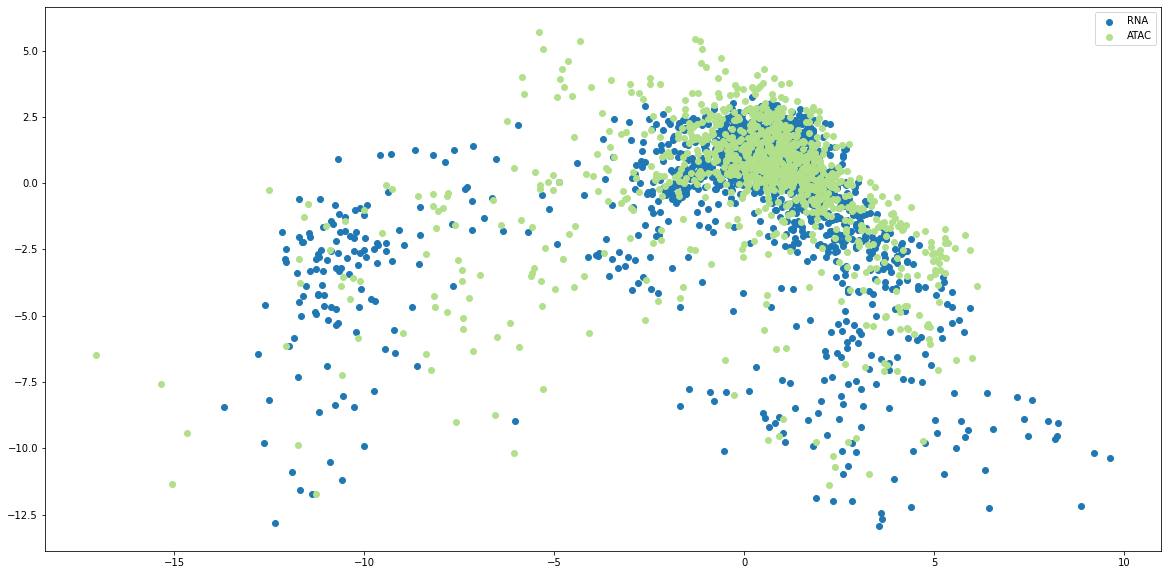

In [17]:
# plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "separate",save = "./result/hm/new/2/separate.pdf")
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "modality",save = None)

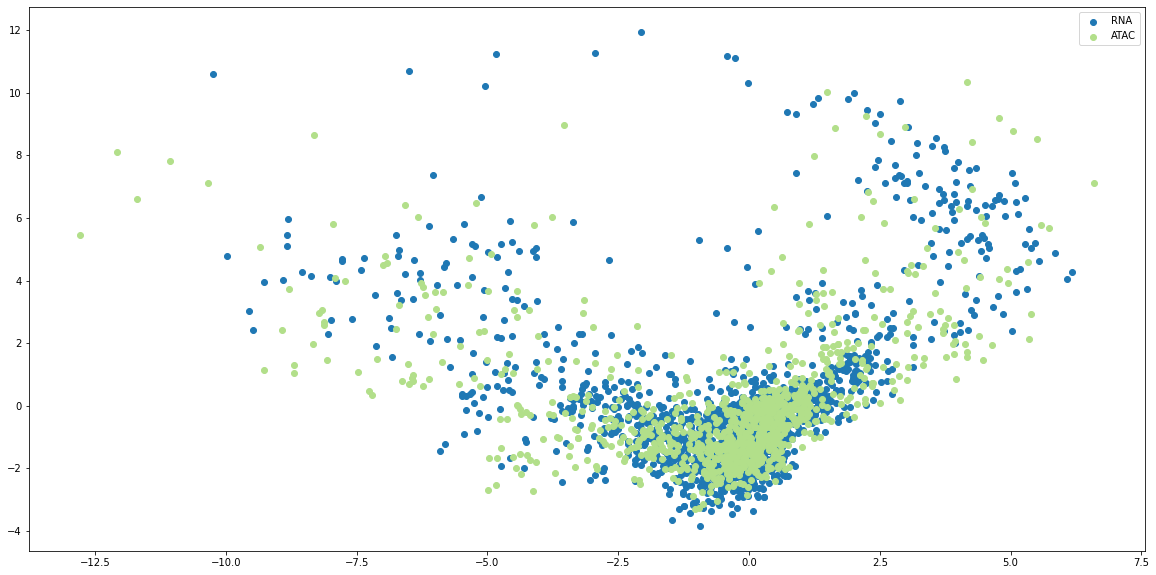

In [27]:
# plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "modality",save = "./result/hm/new/2/modality.pdf")

In [22]:
torch.save({
    'ae1': ae1.state_dict(),
    'optim_ae1': optimizer_rna.state_dict(),
    'ae2': ae2.state_dict(),
    'optim_ae2': optimizer_rna.state_dict(),
    'disc': disc.state_dict(),
    'optim_disc': optimizer_D.state_dict(),
    'config1': symsim_r1b1_CONFIG,
    'config2': symsim_r1b2_CONFIG,
    'Diff1': Diff1,
    'Diff2': Diff2,
}, './saved_model/hm_new2.pt')